In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [76]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform , batch_size=50)

In [121]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                  activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        layers.append(pool_layer)
        layers.append(activation_fn)
      
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)


In [152]:
class ConvLayer2(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxUnpool2d(2, stride=2),
                  activation_fn=nn.ReLU()):
        super(ConvLayer2, self).__init__()
        layers2 = []
        layers2.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding))
        layers2.append(pool_layer)
        layers2.append(activation_fn)   
        self.model = nn.Sequential(*layers2)
    
    def forward(self, x):
        return self.model(x)

In [144]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [178]:
class Encoder(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Encoder, self).__init__()       
        
        self._conv1 = ConvLayer([1, 16, 3])  # b 1  28 28 ->  b 16  14 14 
        self._conv2 = ConvLayer([16, 32, 3], activation_fn=nn.Sigmoid())   # b  16  14 14  -> 32 7 7      
        self.fc = FullyConnected([32*7*7, 10])

    
    def forward(self, x):
        print("E size before _conv1=" , x.shape , x.type())
        x = self._conv1(x)
        print("E size after _conv1=" , x.shape)
        x = self._conv2(x)
        print("E size after _conv2=" , x.shape)
        x = x.view(-1, 32*7*7)
        print("E size after reshape by view=" , x.shape)
        x = F.sigmoid(self.fc(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fct = FullyConnected([10, 32*7*7])
        self._conv21 = ConvLayer2([32,16,3]) 
        self._conv22 = ConvLayer2([16,1,3] , activation_fn=nn.Tanh())
    
    def forward(self, x):
        print("D x before fc=", x.size())
        x = self.fct(x)
        x = F.tanh(x)
        print("D x after fc=", x.size())
        x = x.view(-1, 32, 7, 7)
        print("D x before conv1=", x.size() , x.type())
        x = self._conv21(x)
        print("D x after conv1=", x.size())
        x = self._conv22(x)
#        x = F.tanh(x)
        return x

In [179]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.0001):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder()
        self.D = Decoder()
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        print("E")
        h = self.E(x)
        print("D =" , h.size())
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [180]:
models = {'10': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [181]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data) 
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss))
        print(line + losses)

In [182]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss

    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append((test_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [183]:
for epoch in range(1, 100):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

E
E size before _conv1= torch.Size([50, 1, 28, 28]) torch.FloatTensor
E size after _conv1= torch.Size([50, 16, 14, 14])
E size after _conv2= torch.Size([50, 32, 7, 7])
E size after reshape by view= torch.Size([50, 1568])
D = torch.Size([50, 10])
D x before fc= torch.Size([50, 10])
D x after fc= torch.Size([50, 1568])
D x before conv1= torch.Size([50, 32, 7, 7]) torch.FloatTensor


TypeError: forward() missing 1 required positional argument: 'indices'

In [177]:
data, _ = next(iter(test_loader))
output = models['10'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['10'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28))
    print((encoded > 0.15).sum(1))
    encoded[encoded < 0.15] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

E
E size before _conv1= torch.Size([50, 1, 28, 28]) torch.FloatTensor
E size after _conv1= torch.Size([50, 16, 14, 14])
E size after _conv2= torch.Size([50, 32, 7, 7])
E size after reshape by view= torch.Size([50, 1568])
D = torch.Size([50, 10])
D x before fc= torch.Size([50, 10])
D x after fc= torch.Size([50, 1568])
D x before conv1= torch.Size([50, 32, 7, 7]) torch.FloatTensor


TypeError: forward() missing 1 required positional argument: 'indices'

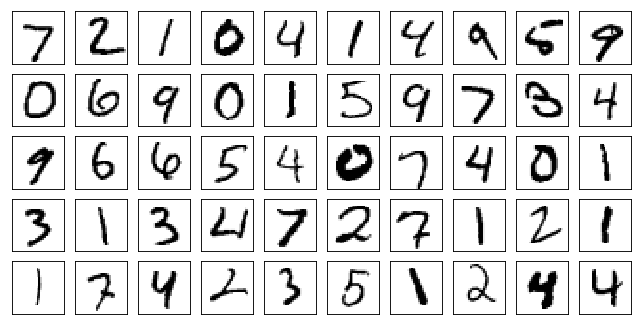

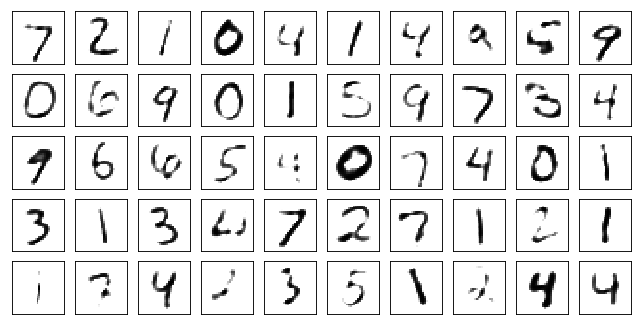

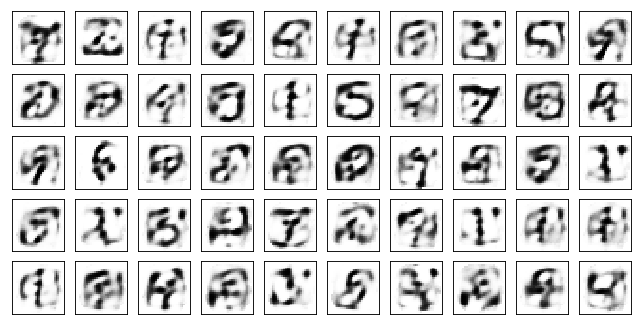

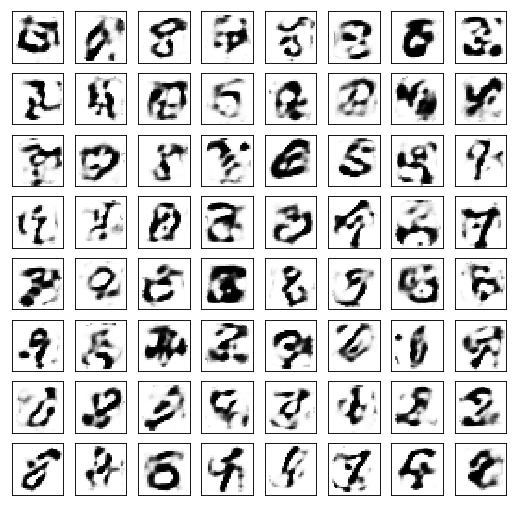

In [14]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))